# Making question

#### Các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # bỏ qua tất cả các cảnh báo
pd.set_option('display.max_columns', None) # hiển thị hết các cột

Đọc dữ liệu từ các file csv đã được làm sạch

In [2]:
match_overview_df = pd.read_csv('./data/clean_data/match_overview.csv', delimiter='\t')
match_statistics_df = pd.read_csv('./data/clean_data/match_statistics.csv', delimiter='\t')
team_ranking_df = pd.read_csv('./data/clean_data/team_rankings.csv', delimiter=',')
team_profile_df = pd.read_csv('./data/clean_data/team_profile.csv', delimiter=',')

## Câu hỏi 1: Mối liên hệ giữa tổng giá trị thị trường và thứ hạng đội bóng?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta:  
- Hiểu rõ mức độ ảnh hưởng của tổng giá trị thị trường đến thứ hạng của các đội bóng.  
- Xác định xem liệu giá trị tài chính có phải là yếu tố quyết định đến thành tích trên bảng xếp hạng.

**Các DataFrame được sử dụng để phân tích:**  
- `team_ranking_df`: Chứa dữ liệu về thứ hạng của các đội bóng.  
- `team_profile_df`: Chứa thông tin chi tiết, bao gồm giá trị thị trường của các đội bóng.  

Merge 2 dataFrame trên lại theo cột `Season` và `Team`

In [3]:
team_profile_df.rename(columns={'Club': 'Team'}, inplace=True)
Q1_merged_df = pd.merge(team_ranking_df, team_profile_df, on=['Season', 'Team'], how='inner')

**Ta sẽ trả lời câu hỏi này bằng cách**: phân tích tổng thể, thông qua việc quan sát giá trị trung bình của `Total market value` và thứ hạng trung bình (`Ranking`) của từng đội bóng qua tất cả các mùa giải mà đội bóng đó tham gia.

In [4]:
Q1_team_avg_stats = Q1_merged_df.groupby('Team')[['Total market value', 'Ranking']].mean().reset_index()

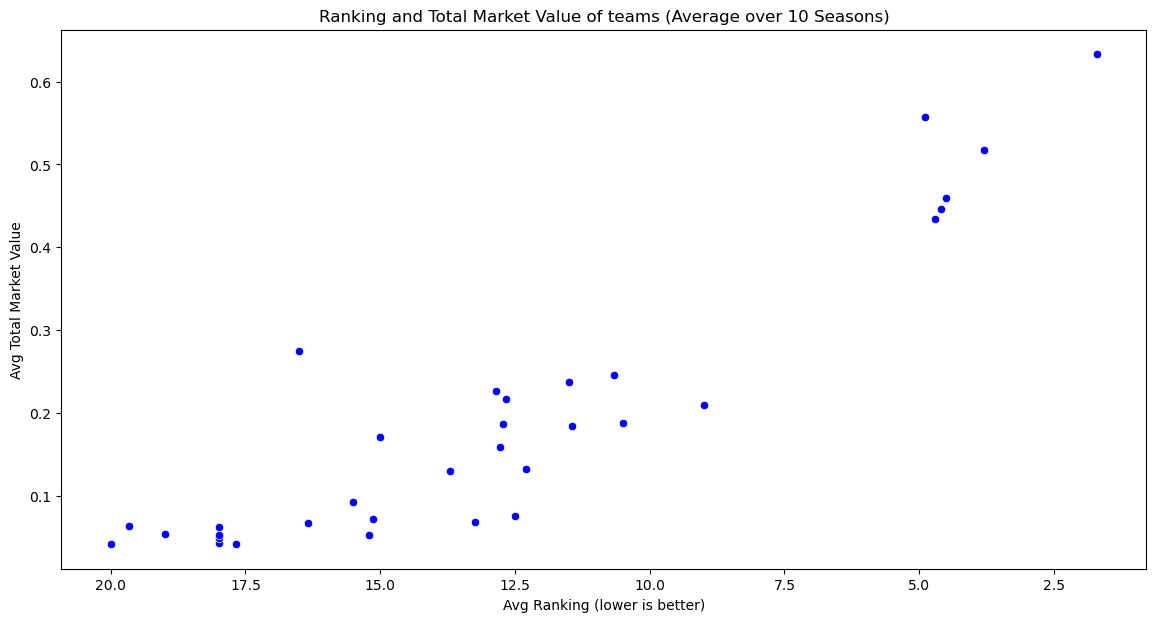

In [5]:
plt.figure(figsize=(14, 7))
scatter_plot = sns.scatterplot(x='Ranking', y='Total market value', data=Q1_team_avg_stats, color='blue')
plt.title('Ranking and Total Market Value of teams (Average over 10 Seasons)')
plt.xlabel('Avg Ranking (lower is better)')
plt.ylabel('Avg Total Market Value')
plt.gca().invert_xaxis()
plt.show()

**Nhận xét**
- Dựa vào biểu đồ ta có thể thấy dường như các đội bóng có tổng giá trị thị trường cao hơn thường có thứ hạng tốt hơn, có nghĩa là các đội bóng đầu tư nhiều thường có thành tích tốt hơn trên bảng xếp hạng.
- Tuy nhiên mối quan hệ không hoàn toàn tuyến tính vì ta có thể thấy từ biểu đồ: không phải tất cả các đội bóng có giá trị thị trường cao đều có thứ hạng cao vì có một số đội bóng có giá trị thị trường khá cao nhưng lại có thứ hạng trung bình hoặc thấp, tương tự cũng có những đội bóng có giá trị thị trường thấp nhưng lại có thứ hạng cao hơn.

**Kết luận**: Tổng giá trị thị trường của một đội bóng có mối liên hệ tích cực với thứ hạng của đội bóng đó. Tuy nhiên mối quan hệ này không phải là tuyệt đối vì để đạt được thành công một đội bóng cần có sự kết hợp hài hòa giữa tài chính, chất lượng đội hình, chiến thuật.

## Câu hỏi 2: Tỷ lệ thắng của các trận đấu khi diễn ra trên sân nhà và trên sân khách qua từng mùa giải như thế nào? Và trung bình cho tất cả mùa giải?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta:
- Hiểu được sự khác biệt về tỷ lệ thắng của các đội bóng khi chơi trên sân nhà và sân khách qua các mùa giải.
- Đánh giá ảnh hưởng của yếu tố sân bãi đến kết quả thi đấu của các đội bóng.

**Các DataFrame được sử dụng để phân tích:**  
- `match_overview.csv`: Chứa dữ liệu về các trận đấu, bao gồm thông tin đội nhà, đội khách, và kết quả trận đấu.

#### 2.1 Đầu tiên ta sẽ xem xét tỉ lệ thắng trên trân nhà và sân khách của từng mùa giải

In [6]:
Q2_data = match_overview_df[['Match ID', 'Season', 'Home Team', 'Away Team', 'Winner']]
Q2_data['Match Results'] = np.select([
        Q2_data['Winner'] == 'Draw',  # 2 nếu kết quả là hòa
        Q2_data['Home Team'] == Q2_data['Winner'],  # 1 nếu đội chủ nhà thắng
        Q2_data['Away Team'] == Q2_data['Winner']  # 0 nếu đội khách thắng
    ], [2, 1, 0], default=np.nan )

In [7]:
season_match_summary = Q2_data.groupby('Season')['Match Results'].value_counts().unstack(fill_value=0)
season_match_summary.columns = ['Away Wins', 'Home Wins', 'Draw']  
season_match_summary['Total Matches'] = season_match_summary.sum(axis=1)  
season_match_summary['% Home Wins'] = season_match_summary['Home Wins'] / season_match_summary['Total Matches'] * 100
season_match_summary['% Away Wins'] = season_match_summary['Away Wins'] / season_match_summary['Total Matches'] * 100

In [ ]:
seasons = season_match_summary.index
home_win_ratio = season_match_summary['% Home Wins'] 
away_win_ratio = season_match_summary['% Away Wins'] 
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(seasons, home_win_ratio, width=0.4, label='% Home Wins', color='blue', align='center')
ax.bar(seasons, season_match_summary['% Away Wins'], width=0.4, label='% Away Wins', color='orange', align='edge')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Win Percentage (%)', fontsize=12)
ax.set_title('Home vs Away Win Percentages by Season', fontsize=14)
ax.legend()

for i in range(len(seasons)):
    ax.text(i, home_win_ratio.iloc[i] + 1, f"{home_win_ratio.iloc[i]:.1f}%", ha='center', color='blue')
    ax.text(i + 0.4, away_win_ratio.iloc[i] + 1, f"{away_win_ratio.iloc[i]:.1f}%", ha='center', color='orange')
    
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Nhận xét**: 
- Từ biểu đồ cột trên, có thể thấy tỉ lệ thắng trên sân nhà cao hơn nhiều so với tỉ lệ thắng trên sân khách hầu như trong tất cả mùa giải, chỉ có duy nhất ở mùa giải 2020/2021 là ngoại lệ khi thì tỉ lệ này ngược lại với tỉ lệ thắng trên sân khách cao hơn.
- Lý do cho sự khác biệt duy nhất này trong mùa giải 2020/2021 có thể là do ảnh hưởng của đại dịch COVID-19, khiến các trận đấu phải diễn ra trên sân không có khán giả, làm giảm đáng kể lợi thế sân nhà vốn phụ thuộc nhiều vào sự cổ vũ của người hâm mộ.

#### 2.2 Cuối cùng là tỉ lệ thắng trên trân nhà và sân khách trung bình của tất cả mùa giải

In [ ]:
labels = ['Home Wins', 'Away Wins', 'Draws']
sizes = [season_match_summary['Home Wins'].sum(), season_match_summary['Away Wins'].sum(), season_match_summary['Draw'].sum()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,counterclock=False, colors=colors)
plt.title('Overall distribution of match results (All Seasons)')
plt.axis('equal')
plt.show()

**Nhận xét:**  
- Dựa trên biểu đồ trung bình của 10 mùa giải gần nhất trên, có thể thấy rằng các trận đấu diễn ra trên sân nhà có tỷ lệ thắng trung bình cao hơn so với sân khách. Điều này có thể được lý giải bởi các yếu tố như sự cổ vũ nhiệt tình từ khán giả đội nhà, giúp cầu thủ chủ nhà nâng cao tinh thần thi đấu và tự tin hơn, ngược lại, đội khách có thể gặp áp lực từ sự cổ vũ của khán giả đối phương, ảnh hưởng đến tâm lý thi đấu. Đồng thời, đội chủ nhà thường quen thuộc với điều kiện sân bãi, thời tiết, giúp họ triển khai chiến thuật một cách hiệu quả hơn.
- Tuy nhiên, tỷ lệ hòa cũng chiếm một phần đáng kể, cho thấy rằng trong nhiều trường hợp, trình độ và chiến thuật giữa hai đội tương đối cân bằng, làm giảm tác động của yếu tố sân bãi.  

**Kết luận:** Như vậy có thể thấy yếu tố sân nhà cũng được xem là một yếu tố quan trọng trong việc quyết định kết quả trận đấu, nhưng không phải là yếu tố quyết định duy nhất đến kết quả trận đấu.

## Câu hỏi 3: Đội bóng nào có tỷ lệ giữ sạch lưới cao nhất qua từng mùa giải và trung bình của tất cả mùa giải? Và tỷ lệ này có ảnh hưởng đến thứ hạng của đội bóng không?

**Ý nghĩa của câu hỏi:**  

Trả lời câu hỏi này sẽ giúp chúng ta:
- Xác định đội bóng có khả năng phòng ngự tốt nhất qua các mùa giải.
- Hiểu rõ mối quan hệ giữa khả năng giữ sạch lưới và thứ hạng của đội bóng, qua đó đánh giá tầm quan trọng của phòng ngự trong thành tích thi đấu.

**Các DataFrame được sử dụng để phân tích:**
- `match_overview.csv`: Chứa dữ liệu về các trận đấu.
- `team_overview.csv`: Chứa thông tin về thứ hạng đội bóng theo từng mùa giải.


#### 3.1 Đầu tiên ta sẽ tính toán tỉ lệ giữ sạch lưới của các đội bóng trong từng mùa giải

In [ ]:
Q3_data = match_overview_df[['Match ID', 'Season','Home Team','Away Team', 'Fulltime Score']]
Q3_data[['Home Goals', 'Away Goals']] = Q3_data['Fulltime Score'].str.split(':', expand=True).astype(int)
Q3_data['Home Clean'] = (Q3_data['Away Goals'] == 0).astype(int)
Q3_data['Away Clean'] = (Q3_data['Home Goals'] == 0).astype(int)

In [ ]:
# tìm số trận đấu giữ sạch lưới của các đội theo từng mùa giải
home_clean_sheets = Q3_data.groupby(['Season', 'Home Team'])['Home Clean'].sum().reset_index()
home_clean_sheets.rename(columns={'Home Team': 'Team', 'Home Clean': 'Clean Matches'}, inplace=True)
away_clean_sheets = Q3_data.groupby(['Season', 'Away Team'])['Away Clean'].sum().reset_index()
away_clean_sheets.rename(columns={'Away Team': 'Team', 'Away Clean': 'Clean Matches'}, inplace=True)
clean_sheets = pd.concat([home_clean_sheets, away_clean_sheets])
clean_sheets = clean_sheets.groupby(['Season', 'Team'])['Clean Matches'].sum().reset_index()

# đếm tất cả số trận đấu mà đội đó tham gia theo từng mùa giải
total_matches_home = Q3_data.groupby(['Season', 'Home Team'])['Match ID'].count().reset_index()
total_matches_home.rename(columns={'Home Team': 'Team', 'Match ID': 'Total Matches'}, inplace=True)
total_matches_away = Q3_data.groupby(['Season', 'Away Team'])['Match ID'].count().reset_index()
total_matches_away.rename(columns={'Away Team': 'Team', 'Match ID': 'Total Matches'}, inplace=True)
total_matches = pd.concat([total_matches_home, total_matches_away])
total_matches = total_matches.groupby(['Season', 'Team'])['Total Matches'].sum().reset_index()

In [ ]:
clean_match_stats = pd.merge(clean_sheets, total_matches, on=['Season', 'Team'])
clean_match_stats['% Clean Match'] = (clean_match_stats['Clean Matches'] / clean_match_stats['Total Matches']) * 100 
clean_match_stats.sort_values(by=['Season', '% Clean Match'], ascending=[True, False], inplace=True)

Ta sẽ trực quan bằng biểu đồ cột xem tỉ lệ giữ sạch lướt của các đội bóng trong 2 mùa giải gần đây nhất

In [ ]:
last_two_seasons = clean_match_stats['Season'].sort_values().unique()[-2:]
filtered_data = clean_match_stats[clean_match_stats['Season'].isin(last_two_seasons)]
plt.figure(figsize=(14, 7))
sns.barplot(x='Team', y='% Clean Match', hue='Season', data=filtered_data, palette='viridis')
plt.title('Clean sheet percentage of Teams in the last two seasons')
plt.xlabel('Teams')
plt.ylabel('Clean sheet percentage (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Nhìn vào biểu đồ trên ta có thể thấy ở mùa giải `2022/2023` thì `Manchester United` là đội bóng có tỷ lệ giữ sạch lưới cao nhất, mùa giải `2023/2024` thì là đội `Arsenal`.
- Các đội có tỷ lệ giữ sạch lưới thấp như: `Burnley FC`, `Luton Town`, `Sheffield United`,..

Đối với trung bình cho tất cả mùa giải

In [ ]:
avg_season_clean_match_stats = clean_match_stats.groupby(['Team'])['% Clean Match'].mean().reset_index()
avg_season_clean_match_stats.sort_values(by=['% Clean Match'], ascending=[False], inplace=True)
plt.figure(figsize=(14, 7))
sns.barplot(x='Team', y='% Clean Match', data=avg_season_clean_match_stats, palette='viridis')
plt.title('Average Clean Sheet Percentage of Teams over all seasons')
plt.xlabel('Teams')
plt.ylabel('Average Clean Sheet Percentage (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### 3.2 Xem mối tương quan giữa tỉ lệ giữ sạch lưới và thứ hạng của đội bóng

In [ ]:
ranking_clean_match = pd.merge(clean_match_stats, team_ranking_df, on=['Season', 'Team'], how='inner')
ranking_clean_match = ranking_clean_match[['Season', 'Team', 'Ranking', '% Clean Match']]
#tính trung bình cho tất cả các mùa
team_avg_stats = ranking_clean_match.groupby('Team')[['Ranking', '% Clean Match']].mean().reset_index()
team_avg_stats.sort_values(by='Ranking', ascending=True, inplace=True)
team_avg_stats.reset_index(drop=True, inplace=True)
team_avg_stats

In [ ]:
plt.figure(figsize=(14, 7))
sns.regplot(x='Ranking',y='% Clean Match', data=team_avg_stats, scatter=False, color='red',line_kws={'linestyle': '--'})
sns.scatterplot(x='Ranking', y='% Clean Match', data=team_avg_stats, color='blue', s=100)
plt.title('Correlation between Ranking and Clean Sheet Percentage')
plt.xlabel('Ranking (Lower is Better)')
plt.ylabel('Clean Sheet Percentage (%)')
plt.gca().invert_xaxis()  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Nhận xét**:
- Dựa trên biểu đồ, ta có thể đưa ra kết luận rằng: **tỷ lệ giữ sạch lưới của một đội bóng có ảnh hưởng rất lớn đến thứ hạng của đội bóng**.
- Đường hồi quy cho ta thấy các đội bóng có tỷ lệ giữ sạch lưới cao thường có thứ hạng tốt hơn so với các đội bóng có tỷ lệ giữ sạch lưới thấp.
- Điều này có thể giải thích rằng việc giữ sạch lưới là một yếu tố quan trọng quyết định kết quả của một trận đấu. Một đội bóng có hàng phòng ngự chắc chắn sẽ ít bị thủng lưới hơn, từ đó có nhiều cơ hội giành chiến thắng hoặc hòa.

**Kết luận**: Một đội bóng muốn đạt được thành tích cao cần phải có cả khả năng tấn công tốt và phòng ngự chắc chắn. Khả năng giữ sạch lưới đóng vai trò quan trọng trong việc đảm bảo sự ổn định và hiệu quả của đội bóng.

## Câu hỏi 4: Số lần phạm lỗi giữa top 5 đội có thứ hạng cao nhất với top 5 đội có thứ hạng thấp nhất có sự khác nhau như nào?

**Ý nghĩa của câu hỏi:**  
Trả lời câu hỏi này sẽ giúp chúng ta:
- Hiểu được sự khác biệt về lối chơi và số lần phạm lỗi giữa các đội có thứ hạng cao và thấp trong các mùa giải.
- Đánh giá được yếu tố ảnh hưởng đến phong độ thi đấu của các đội, từ đó rút ra được nhận xét về chiến thuật và phong cách chơi giữa các đội mạnh và yếu.

**Các DataFrame được sử dụng để phân tích:**
- `match_overview.csv`: Chứa thông tin tổng quan về các trận đấu, bao gồm các đội tham gia và kết quả của trận đấu,...
- `match_statistic.csv`: Cung cấp các số liệu thống kê chi tiết của từng trận đấu: số lần phạm lỗi của các đội và các chỉ số khác liên quan đến lối chơi.
- `team_ranking.csv`: Ghi nhận thứ hạng của các đội qua từng mùa giải, giúp phân loại và so sánh các đội theo thứ hạng cao và thấp để thực hiện phân tích.

#### 4.1 Đầu tiên ta sẽ xem sét tổng số lỗi của các đội có thuộc top 5 đội có thứ hạng cao nhất và thấp nhất của 2 mùa giả 22/23 và 23/24

Để đảm bảo tính chính xác và tránh sai lệch trong phân tích, ở câu hỏi này chúng em chỉ sử dụng dữ liệu từ 2 mùa giải gần nhất. Lý do là các mùa giải trước đây có sự biến động về số lượng đội tham gia, khi một số đội không còn góp mặt. Việc tập trung vào 2 mùa gần nhất đảm bảo rằng số đội tham gia là cố định, từ đó mang lại kết quả trực quan và đáng tin cậy hơn.

Merge DataFrame  `match_overview_df` và `match_statistics_df` để lấy thông tin mùa giải và các đội

In [ ]:
Q4_data = pd.merge(match_overview_df, match_statistics_df, left_on=['Match ID'], right_on=['match_id'], how='inner')
Q4_data = Q4_data[['Match ID', 'Season', 'Away Team', 'Home Team','home_fouls', 'away_fouls']]

Tìm tổng số bàn lỗi của từng đội theo từng mùa giải

In [ ]:
home_total_fouls = Q4_data.groupby(['Season', 'Home Team'])['home_fouls'].sum().reset_index()
home_total_fouls.rename(columns={'Home Team': 'Team', 'home_fouls': 'Total Fouls'}, inplace=True)
away_total_fouls = Q4_data.groupby(['Season', 'Away Team'])['away_fouls'].sum().reset_index()
away_total_fouls.rename(columns={'Away Team': 'Team', 'away_fouls': 'Total Fouls'}, inplace=True)
total_fouls = pd.concat([home_total_fouls, away_total_fouls])
total_fouls = total_fouls.groupby(['Season', 'Team'])['Total Fouls'].sum().reset_index()

Tìm các đội có thứ hạng thuộc top 5 cao nhất và thấp nhất qua 2 mùa giải 

In [ ]:
team_ranking_df.sort_values(by=['Season','Ranking'], ascending=[True, True], inplace=True)
top_5_ranking = team_ranking_df.groupby('Season').head(5).reset_index(drop=True)
bottom_5_ranking = team_ranking_df.groupby('Season').tail(5).reset_index(drop=True)

Tìm số lỗi của các đội có thứ hạng thuộc top 5 cao nhất và thấp nhất qua 2 mùa giải 


In [ ]:
top_5_ranking_fouls = pd.merge(top_5_ranking,total_fouls, on=['Season','Team'], how='inner')
bottom_5_ranking_fouls = pd.merge(bottom_5_ranking,total_fouls, on=['Season','Team'], how='inner')

top_5_ranking_fouls_2223 = top_5_ranking_fouls[top_5_ranking_fouls['Season'] == '22/23']
bottom_5_ranking_fouls_2223 = bottom_5_ranking_fouls[bottom_5_ranking_fouls['Season'] == '22/23']

top_5_ranking_fouls_2324 = top_5_ranking_fouls[top_5_ranking_fouls['Season'] == '23/24']
bottom_5_ranking_fouls_2324 = bottom_5_ranking_fouls[bottom_5_ranking_fouls['Season'] == '23/24']

Trực quan hóa dữ liệu thành 2 biểu đồ tương ứng cho 2 mùa giải

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_5_ranking_fouls_2223['Team'], top_5_ranking_fouls_2223['Total Fouls'], color='blue', label='Top 5 Teams')
plt.bar(bottom_5_ranking_fouls_2223['Team'], bottom_5_ranking_fouls_2223['Total Fouls'], color='orange', label='Bottom 5 Teams')
plt.title("Foul counts - Season 22/23")
plt.xlabel("Teams")
plt.ylabel("Total foul counts")
plt.xticks(rotation=90)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(top_5_ranking_fouls_2324['Team'], top_5_ranking_fouls_2324['Total Fouls'], color='blue', label='Top 5 Teams')
plt.bar(bottom_5_ranking_fouls_2324['Team'], bottom_5_ranking_fouls_2324['Total Fouls'], color='orange', label='Bottom 5 Teams')
plt.title("Foul counts - Season 23/24")
plt.xlabel("Teams")
plt.ylabel("Total foul counts")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét**:
- Từ biểu đồ ta có thể thấy, các đội trong top 5 đội có thứ hạng thấp nhất ở cả hai mùa thường có số lỗi cao và đồng đều với nhau cho thấy lối chơi của họ có xu hướng phạm lỗi nhiều hơn. Còn ở các đội top đầu, có sự phân hóa rõ rệt trong lối chơi của các đội trong khi có cả những đội có số lỗi nhiều nhất và có số lỗi ít nhất.
- **Manchester City** là đội đứng đầu cũng như là đội có số lỗi thấp nhất qua cả hai mùa, cho thấy lối chơi kiểm soát tốt và ít phạm lỗi.
- **Liverpool** có số lỗi cao qua cả hai mùa trong nhóm top 5 kể cả với các đội có thứ hạng thấp nhất, phản ánh lối chơi mạnh mẽ dễ phạm lỗi của đội này.

4.2 Để rõ hơn, ta sẽ xem xét trung bình số lỗi của các đội top 5 cao nhất và thấp nhất ở hai mùa giải này

In [ ]:
avg_top_5_ranking_fouls_2223 = top_5_ranking_fouls_2223['Total Fouls'].mean()
avg_bottom_5_ranking_fouls_2223 = bottom_5_ranking_fouls_2223['Total Fouls'].mean()
avg_top_5_ranking_fouls_2324 = top_5_ranking_fouls_2324['Total Fouls'].mean()
avg_bottom_5_ranking_fouls_2324 = bottom_5_ranking_fouls_2324['Total Fouls'].mean()

In [ ]:
avg_fouls = { "Top 5 Teams": [avg_top_5_ranking_fouls_2223, avg_top_5_ranking_fouls_2324], "Bottom 5 Teams": [avg_bottom_5_ranking_fouls_2223, avg_bottom_5_ranking_fouls_2324]}
seasons = ['22/23', '23/24']
x = np.arange(len(seasons)) 
width = 0.35  
plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, avg_fouls['Top 5 Teams'], width, label='Top 5 Teams', color='blue')
plt.bar(x + width / 2, avg_fouls['Bottom 5 Teams'], width, label='Bottom 5 Teams', color='orange')
plt.title('Average foul counts of top 5 and bottom 5 teams')
plt.xlabel('Seasons')
plt.ylabel('Average foul counts')
plt.xticks(x, seasons)
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**
- Biểu đồ trên cho thấy, trong cả hai mùa, các đội trong nhóm **5 đội hạng cao nhất** có số lỗi trung bình cao hơn so với các đội trong nhóm **5 đội hạng thấp nhất**.
- Sự chênh lệch về số lần phạm lỗi giữa hai nhóm này có xu hướng lớn hơn trong mùa giải 22/23 so với mùa 23/24, cho thấy có sự thay đổi trong lối chơi của các đội này qua các mùa.

**Kết luận:**
- Số lần phạm lỗi giữa các đội có thứ hạng cao nhất (top 5) và các đội có thứ hạng thấp nhất (bottom 5) cho thấy sự khác biệt rõ rệt. Các đội trong top 5 cao nhất có xu hướng chơi mạnh mẽ và tạo ra nhiều tình huống phạm lỗi hơn, có thể do lối chơi tấn công quyết liệt và áp lực cao. Ngược lại, các đội trong nhóm 5 đội thấp nhất thường chơi phòng ngự chặt chẽ và ít tạo ra các tình huống phạm lỗi.
- Sự khác biệt này chỉ ra rằng các đội mạnh hơn có xu hướng chơi với áp lực cao và nhiều pha phạm lỗi, trong khi các đội yếu hơn có lối chơi thiên về phòng thủ và tránh được nhiều tình huống phạm lỗi.